In [1]:
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from math import sqrt
import random
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
df = pd.read_csv("data/hour.csv", parse_dates=["dteday"])
y = df['cnt'].astype(float).dropna()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
n = len(y)

train_size = int(0.7 * n)
val_size   = int(0.15 * n)
test_size  = n - train_size - val_size

y_train = y.iloc[:train_size]
y_val   = y.iloc[train_size:train_size+val_size]
y_test  = y.iloc[train_size+val_size:]

print(f"Train={len(y_train)} ({len(y_train)/n:.1%})")
print(f"Val  ={len(y_val)}   ({len(y_val)/n:.1%})")
print(f"Test ={len(y_test)}  ({len(y_test)/n:.1%})")

Train=12165 (70.0%)
Val  =2606   (15.0%)
Test =2608  (15.0%)


In [ ]:
# Initialize and fit scaler on training data
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()

# Apply same transform to val/test
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1,1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).ravel()

print("Scaled train mean:", round(y_train_scaled.mean(),3))
print("Scaled train std :", round(y_train_scaled.std(),3))

Scaled train mean: -0.0
Scaled train std : 1.0


In [5]:

LOOKBACK = 48   # history length; adjust later if needed
HORIZON  = 1    # one-step ahead

def make_windows(arr, lookback=LOOKBACK, horizon=HORIZON):
    X, y = [], []
    for t in range(lookback, len(arr) - horizon + 1):
        X.append(arr[t-lookback:t])           # last `lookback` points
        y.append(arr[t + horizon - 1])        # next point
    X = np.array(X, dtype=np.float32)[:, :, None]  # add feature dim -> [N, L, 1]
    y = np.array(y, dtype=np.float32)                # [N]
    return X, y

X_tr, y_tr = make_windows(y_train_scaled)
X_va, y_va = make_windows(y_val_scaled)
X_te, y_te = make_windows(y_test_scaled)

print("Train windows:", X_tr.shape, y_tr.shape)
print("Val   windows:", X_va.shape, y_va.shape)
print("Test  windows:", X_te.shape, y_te.shape)


Train windows: (12117, 48, 1) (12117,)
Val   windows: (2558, 48, 1) (2558,)
Test  windows: (2560, 48, 1) (2560,)


In [6]:


class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_ds = SeqDataset(X_tr, y_tr)
val_ds   = SeqDataset(X_va, y_va)
test_ds  = SeqDataset(X_te, y_te)

# Create loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Batches → train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))


Batches → train: 190 val: 40 test: 40


In [ ]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__() # call parent constructor
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)  # one-step forecast

    def forward(self, x):
        # x: [batch, time, features] = [B, L, 1]
        out, _ = self.lstm(x)        # out: [B, L, H]
        last = out[:, -1, :]         # [B, H]  (summary of the window)
        yhat = self.fc(last).squeeze(-1)  # [B]
        return yhat

# Instantiate the model (features=1 for univariate)
model = LSTMForecaster(input_size=1, hidden_size=64, num_layers=1, dropout=0.0)
print(model)

LSTMForecaster(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10
PATIENCE = 3

best_val = float("inf")
best_state = None
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    # ---- train ----
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # ---- validate ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:03d} | train MSE: {train_loss:.4f} | val MSE: {val_loss:.4f}")

    # ---- early stopping ----
    if val_loss + 1e-8 < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# load best weights
if best_state is not None:
    model.load_state_dict(best_state)
model = model.to(DEVICE)

Epoch 001 | train MSE: 0.4686 | val MSE: 0.4598
Epoch 002 | train MSE: 0.2022 | val MSE: 0.2785
Epoch 003 | train MSE: 0.1467 | val MSE: 0.2032
Epoch 004 | train MSE: 0.1156 | val MSE: 0.1631
Epoch 005 | train MSE: 0.1105 | val MSE: 0.1610
Epoch 006 | train MSE: 0.0841 | val MSE: 0.1316
Epoch 007 | train MSE: 0.0763 | val MSE: 0.1200
Epoch 008 | train MSE: 0.0693 | val MSE: 0.1177
Epoch 009 | train MSE: 0.0656 | val MSE: 0.1181
Epoch 010 | train MSE: 0.0632 | val MSE: 0.1170


LSTM → Train MAE=30.422 RMSE=47.174
LSTM → Val   MAE=36.670 RMSE=52.181
LSTM → Test  MAE=36.584 RMSE=54.088
Naïve → Train MAE=55.776 RMSE=86.107
Naïve → Val   MAE=92.675 RMSE=135.988
Naïve → Test  MAE=80.555 RMSE=124.516


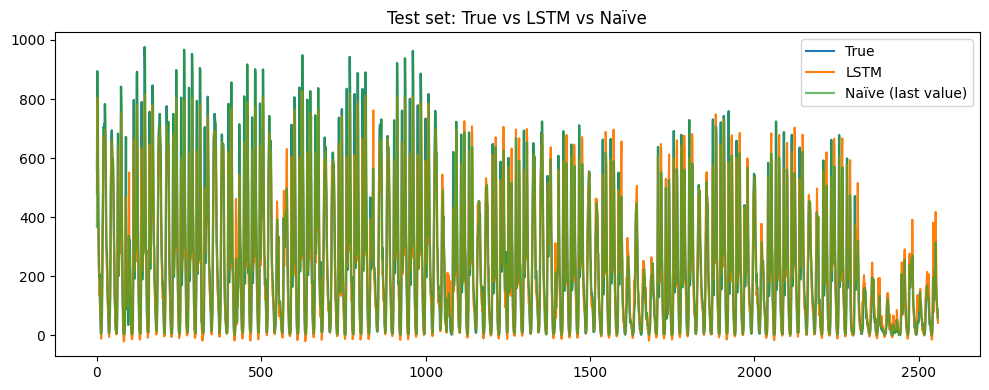

In [9]:
def eval_loader(model, loader, scaler_y):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yhat = model(xb).cpu().numpy()
            preds.append(yhat)
            trues.append(yb.numpy())
    preds = np.concatenate(preds)              # scaled
    trues = np.concatenate(trues)              # scaled

    # inverse transform back to original scale
    preds_inv = scaler_y.inverse_transform(preds.reshape(-1,1)).ravel()
    trues_inv = scaler_y.inverse_transform(trues.reshape(-1,1)).ravel()

    mae  = np.mean(np.abs(preds_inv - trues_inv))
    rmse = sqrt(np.mean((preds_inv - trues_inv)**2))
    return mae, rmse, preds_inv, trues_inv

# LSTM performance
mae_tr, rmse_tr, yhat_tr, ytrue_tr = eval_loader(model, train_loader, scaler_y)
mae_va, rmse_va, yhat_va, ytrue_va = eval_loader(model, val_loader,   scaler_y)
mae_te, rmse_te, yhat_te, ytrue_te = eval_loader(model, test_loader,  scaler_y)

print(f"LSTM → Train MAE={mae_tr:.3f} RMSE={rmse_tr:.3f}")
print(f"LSTM → Val   MAE={mae_va:.3f} RMSE={rmse_va:.3f}")
print(f"LSTM → Test  MAE={mae_te:.3f} RMSE={rmse_te:.3f}")

# ---- Naïve baseline (last value in the window) on each split ----
def naive_from_Xy(X_seq, y_seq, scaler_y):
    # X_seq is scaled; last value of each window is X[:, -1, 0]
    naive_scaled = X_seq[:, -1, 0]
    naive_inv = scaler_y.inverse_transform(naive_scaled.reshape(-1,1)).ravel()
    y_inv     = scaler_y.inverse_transform(y_seq.reshape(-1,1)).ravel()
    mae  = np.mean(np.abs(naive_inv - y_inv))
    rmse = sqrt(np.mean((naive_inv - y_inv)**2))
    return mae, rmse

na_tr_mae, na_tr_rmse = naive_from_Xy(X_tr, y_tr, scaler_y)
na_va_mae, na_va_rmse = naive_from_Xy(X_va, y_va, scaler_y)
na_te_mae, na_te_rmse = naive_from_Xy(X_te, y_te, scaler_y)

print(f"Naïve → Train MAE={na_tr_mae:.3f} RMSE={na_tr_rmse:.3f}")
print(f"Naïve → Val   MAE={na_va_mae:.3f} RMSE={na_va_rmse:.3f}")
print(f"Naïve → Test  MAE={na_te_mae:.3f} RMSE={na_te_rmse:.3f}")

# ---- Optional quick plot on the test set ----
try:
    
    plt.figure(figsize=(10,4))
    plt.plot(ytrue_te, label="True")
    plt.plot(yhat_te, label="LSTM")
    plt.plot(scaler_y.inverse_transform(X_te[:, -1, 0].reshape(-1,1)).ravel(),
             label="Naïve (last value)", alpha=0.7)
    plt.title("Test set: True vs LSTM vs Naïve")
    plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print("Plot skipped:", e)

In [10]:
# Prepare traces
trace_true = go.Scatter(
    y=ytrue_te,
    mode='lines',
    name='True'
)

trace_lstm = go.Scatter(
    y=yhat_te,
    mode='lines',
    name='LSTM'
)

trace_naive = go.Scatter(
    y=scaler_y.inverse_transform(X_te[:, -1, 0].reshape(-1,1)).ravel(),
    mode='lines',
    name='Naïve (last value)',
    line=dict(dash='dot')
)

# Build the figure
fig = go.Figure([trace_true, trace_lstm, trace_naive])
fig.update_layout(
    title="Test set: True vs LSTM vs Naïve",
    xaxis_title="Time step (relative in test set)",
    yaxis_title="Target value",
    template="plotly_white",
    legend=dict(x=0, y=1, bgcolor='rgba(0,0,0,0)')
)

fig.show()

In [12]:
from torchinfo import summary

model = LSTMForecaster(input_size=1, hidden_size=64, num_layers=1, dropout=0.0)
summary(model, input_size=(32, 24, 1))  # [batch, time, features]


Layer (type:depth-idx)                   Output Shape              Param #
LSTMForecaster                           [32]                      --
├─LSTM: 1-1                              [32, 24, 64]              17,152
├─Linear: 1-2                            [32, 1]                   65
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 13.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 0.07
Estimated Total Size (MB): 0.47

In [20]:
a = [1, 2, 3]
print(torch.tensor(a).squeeze(-1))

tensor([1, 2, 3])


In [21]:
torch.backends.mps.is_available()


True

In [25]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [26]:
print(device)

mps
